In [1]:
import os
import pandas as pd

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
absolute_path = '/Users/aygalic/OneDrive/polimi/Thesis/data/quant/'

# Exploring the Dataset

In [3]:
# getting entries ready
# each couple of entries correspond to one patient

entries = os.listdir(absolute_path)
entries_transcripts = [e for e in entries if "transcripts" in e ]

# Building a TensorFlow input pipeline

## We want to build a tf.Dataset from this

In [4]:
# from filename to tensor

def load_patient_data(filename):
  #specify read types for our data
  read_types = [ float()]
  # get a first sample to base everything of
  text = pathlib.Path(absolute_path + filename).read_text()
  lines = text.split('\n')[1:-1]
  features = tf.io.decode_csv(lines, record_defaults=read_types, field_delim = "\t", select_cols=[3]) 
  data = tf.convert_to_tensor(features)

  return data

# Feed it into a net

In [5]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras

# now we build a tf.dataset with all patients inside


In [6]:
# load the dataset into a list using the first pipeline

train_ds = [load_patient_data(e) for e in entries_transcripts]
train_ds = [e for e in train_ds if e.shape == (1, 95309)] 

In [9]:
# turn it into a tf.data.Dataset object
x_train = tf.data.Dataset.from_tensor_slices(train_ds)



In [10]:
# input are the same as the target
zipped_boi = tf.data.Dataset.zip((x_train, x_train))


In [62]:
#(iter(zipped_boi))

# train it

In [49]:
latent_dim = 64
t_shape = (1, 95309)


class Autoencoder(Model):
  #layer = tf.keras.layers.experimental.preprocessing.Normalization()
  #layer.adapt(X_train)
  def __init__(self, latent_dim, normalization = True):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.BatchNormalization(),
      layers.Dense(latent_dim, activation='softplus'),
      layers.Dense(latent_dim, activation='softplus'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(latent_dim, activation='softplus'),
      layers.Dense(1 * 95309, activation='softplus'), # softplus so we can have value in the expected range
      layers.Reshape(t_shape)
    ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)


autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [12]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
latent_dim = 64

t_shape = (1, 95309)

#encoder_inputs = keras.Input(shape=t_shape)
#x = layers.Flatten()(encoder_inputs)

encoder_inputs = layers.Flatten()



x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 95309)]   0           []                               
                                                                                                  
 flatten (Flatten)              (None, 95309)        0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 16)           1524960     ['flatten[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 64)           1088        ['dense[0][0]']                  
                                                                                            

In [16]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
decoder_outputs = layers.Dense(1 * 95309, activation='softplus')(x), # softplus so we can have value in the expected range
#decoder_outputs = layers.Reshape(t_shape)(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_5 (Dense)             (None, 3136)              203840    
                                                                 
 dense_6 (Dense)             (None, 95309)             298984333 
                                                                 
Total params: 299,188,173
Trainable params: 299,188,173
Non-trainable params: 0
_________________________________________________________________


In [17]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [18]:
#(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255


vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())


In [22]:
#vae.fit(zipped_boi, epochs=30, batch_size=128)
vae.fit(x_train, epochs=30)




Epoch 1/30


ValueError: in user code:

    File "/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_43545/2449247714.py", line 22, in train_step
        z_mean, z_log_var, z = self.encoder(data)
    File "/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "encoder" is incompatible with the layer: expected shape=(None, 1, 95309), found shape=(1, 95309)


In [50]:
hist = autoencoder.fit(zipped_boi,
                epochs=10,
                shuffle=False)

Epoch 1/10


4755/4755 [==============================] - 256s 54ms/step - loss: 50037.5977
Epoch 2/10
4755/4755 [==============================] - 256s 54ms/step - loss: 49595.7070
Epoch 3/10
4755/4755 [==============================] - 296s 62ms/step - loss: 49558.0820
Epoch 4/10
4755/4755 [==============================] - 297s 62ms/step - loss: 49515.7422
Epoch 5/10
4755/4755 [==============================] - 268s 56ms/step - loss: 49461.5156
Epoch 6/10
4755/4755 [==============================] - 220s 46ms/step - loss: 49422.7031
Epoch 7/10
4755/4755 [==============================] - 206s 43ms/step - loss: 49384.5352
Epoch 8/10
4755/4755 [==============================] - 192s 40ms/step - loss: 49351.1133
Epoch 9/10
4755/4755 [==============================] - 193s 41ms/step - loss: 49327.9727
Epoch 10/10
4755/4755 [==============================] - 200s 42ms/step - loss: 49303.5312


[8458.9609375, 5196.03369140625, 3719.23828125, 3157.94580078125, 2965.247802734375, 2837.5986328125, 2734.477783203125, 2659.512939453125, 2532.032958984375, 2480.10498046875]


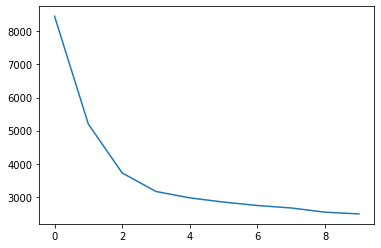

In [11]:

plt.plot(hist.history['loss'])

print(hist.history['loss'])


In [51]:
#autoencoder.save('../workfiles/placeholder_model')
autoencoder.save('../workfiles/placeholder_normalized_model')

INFO:tensorflow:Assets written to: ../workfiles/placeholder_normalized_model/assets


INFO:tensorflow:Assets written to: ../workfiles/placeholder_normalized_model/assets
